In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

/Users/eddieqiao/miniconda3/envs/in-context-learning/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
task = "ar_mixture_multirun"

run_id = "ad7cbf71-4eba-4712-a137-fd3d220893d5" 

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [3]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [ ]:
model, conf = get_model_from_run(run_path)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size


# # Convert task_kwargs properly
task_kwargs = {}
if hasattr(conf.training, 'task_kwargs') and conf.training.task_kwargs:
    if hasattr(conf.training.task_kwargs, '__dict__'):
        task_kwargs = conf.training.task_kwargs.__dict__ 
    else:
        task_kwargs = conf.training.task_kwargs

# # Configure data sampler based on task type
# if conf.training.task == "ar_warmup":
#     # Use the final lag value from curriculum configuration
#     lag_value = conf.training.curriculum.lag.end
#     assert isinstance(lag_value, int), "lag must be an integer"
#     data_sampler = get_data_sampler("ar_warmup", n_dims=n_dims, lag=lag_value)
#     # Add lag to task_kwargs for task sampler
#     task_kwargs["lag"] = lag_value
#     # print(data_sampler.current_coefficients)
#     # print("coeffs", task_kwargs["coefficients"])
# else:
#     data_sampler = get_data_sampler(conf.training.data, n_dims=conf.training.curriculum.dims.start)
n_dims = conf.model.n_dims
num_runs = (n_dims + 1) // 2
lag_value = conf.training.curriculum.lag.end
noise_std = task_kwargs.get('noise_std', 0.2)
num_mixture_models = task_kwargs.get('num_mixture_models', 8)


data_sampler = get_data_sampler(
    "ar_mixture", 
    n_dims=n_dims,
    lag=lag_value, 
    noise_std=noise_std, 
    num_mixture_models=num_mixture_models,
    num_runs=num_runs,
    use_gpu=False
)


/Users/eddieqiao/Documents/mit/fall-2025/urop/in-context-learning/src/eval.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path, map_location='

### Analysis for ar_mixture

In [5]:
n_dims = conf.model.n_dims
num_runs = (n_dims + 1) // 2

lag_value = conf.training.curriculum.lag.end
noise_std = task_kwargs.get('noise_std', 0.2)
num_mixture_models = task_kwargs.get('num_mixture_models', 8)

data_sampler = get_data_sampler(
    "ar_mixture", 
    n_dims=n_dims,
    lag=lag_value, 
    noise_std=noise_std, 
    num_mixture_models=num_mixture_models,
    num_runs=num_runs,
    use_gpu=False
)

coeff_pool_path = os.path.join(run_path, "coefficient_pool.pt")
data_sampler.coefficient_pool = torch.load(coeff_pool_path)

filtered_task_kwargs = {k: v for k, v in task_kwargs.items() 
                       if k not in ['num_mixture_models', 'noise_std', 'num_runs']}
filtered_task_kwargs["lag"] = lag_value
filtered_task_kwargs["num_runs"] = num_runs

task_sampler = get_task_sampler("ar_mixture", n_dims, batch_size, **filtered_task_kwargs)


/var/folders/b1/0bl0pk310ng25nj8320m_pnh0000gn/T/ipykernel_15159/3984078477.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_sampler.coefficient_pool = torch.load(c

In [6]:
n_points = conf.training.curriculum.points.end
xs = data_sampler.sample_xs(n_points, batch_size, n_dims)
ys = data_sampler.current_ys

In [7]:
with torch.no_grad():
    pred = model(xs, ys)

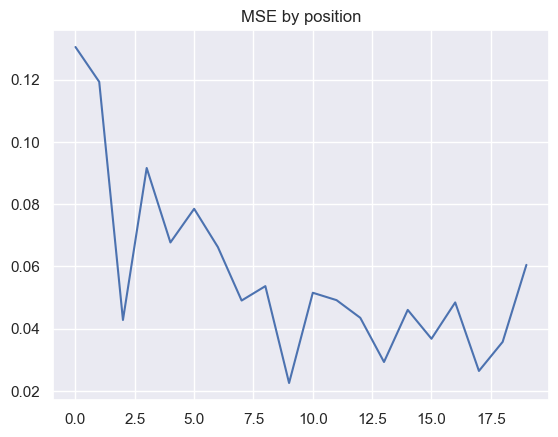

In [8]:
mse_by_position = ((pred - ys) ** 2).mean(dim=0)
plt.plot(mse_by_position.numpy())
plt.title('MSE by position')
plt.show()

In [ ]:
mse_by_position



tensor([0.2094, 0.1531, 0.0919, 0.1492, 0.1112, 0.0747, 0.1047, 0.0598, 0.0342,
        0.0635, 0.0404, 0.0397, 0.0664, 0.0187, 0.0452, 0.0460, 0.0225, 0.0435,
        0.0285, 0.0359])

### Analysis for ar_warmup

In [9]:
with torch.no_grad():
    pred = model(xs, ys)

In [58]:
xs[1], ys[1], pred[1]

(tensor([[-0.4815, -0.2918,  0.6262, -0.2203, -0.4322,  0.5616, -0.3046, -0.3674,
           0.2704,  0.1108,  0.9346, -0.4546,  0.1169, -0.2669,  0.6059,  0.1779,
           0.3103,  0.6048, -0.1558,  0.1774, -0.1709, -0.2856,  0.3226, -0.1234,
           0.2882,  0.6786,  0.1725, -0.1707, -0.2800, -0.0846,  0.4476, -0.6794,
          -0.1437,  0.0649,  0.5895,  0.4059, -0.1111, -0.3716, -0.0398],
         [-0.2918, -0.4806, -0.2203,  0.0879,  0.5616,  0.3838, -0.3674,  0.0425,
           0.1108,  0.6808, -0.4546, -0.8588, -0.2669,  0.2630,  0.1779,  0.4576,
           0.6048, -0.9111,  0.1774,  0.3718, -0.2856, -0.5113, -0.1234,  0.0037,
           0.6786,  0.0605, -0.1707, -0.4844, -0.0846,  0.0500, -0.6794, -0.5903,
           0.0649, -0.0298,  0.4059, -0.3283, -0.3716, -0.4342, -0.1345],
         [-0.4806,  0.2838,  0.0879,  0.3489,  0.3838,  0.0611,  0.0425,  0.0420,
           0.6808,  0.1636, -0.8588, -0.3826,  0.2630,  0.1649,  0.4576, -0.5234,
          -0.9111,  0.2217,  0.3

Model 0.08656976372003555
Oracle (argmax) 0.07524139434099197
Oracle (Bayesian) 0.07662276923656464
Noise Floor 0.04000000000000001


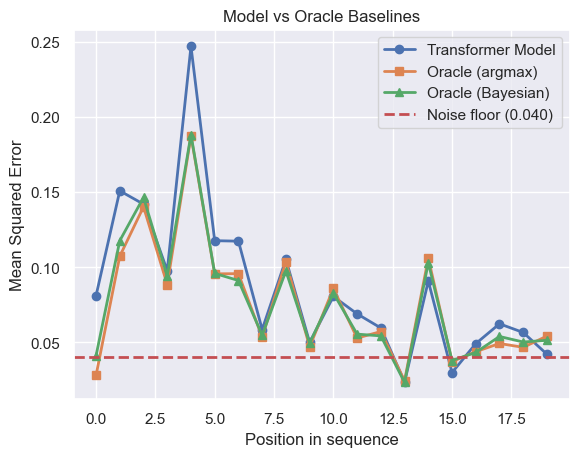

In [16]:
import numpy as np

# Begin with uniform prior
def compute_oracle_hard_assignment(xs, ys, coefficient_pool, noise_std, lag):
    batch_size, n_points, _ = xs.shape
    num_models = coefficient_pool.shape[0]
    
    log_posteriors = torch.zeros(batch_size, num_models)
    predictions = torch.zeros(batch_size, n_points)
    selected_models = torch.zeros(batch_size, n_points, dtype=torch.long)
    
    # Same as the "soft" assignment, but we just take the max instead
    for t in range(n_points):
        x_t = xs[:, t, :lag]
        y_t = ys[:, t]
        
        predictions_per_model = x_t @ coefficient_pool.T
        residuals = y_t.unsqueeze(1) - predictions_per_model
        log_likelihood = -0.5 * np.log(2 * np.pi * noise_std**2) - 0.5 * (residuals**2) / (noise_std**2)
        log_posteriors = log_posteriors + log_likelihood
        
        best_models = log_posteriors.argmax(dim=1)
        selected_models[:, t] = best_models
        
        for b in range(batch_size):
            predictions[b, t] = predictions_per_model[b, best_models[b]]
    
    return predictions, selected_models


def compute_oracle_soft_assignment(xs, ys, coefficient_pool, noise_std, lag):
    batch_size, n_points, _ = xs.shape
    num_models = coefficient_pool.shape[0]
    
    log_posteriors = torch.zeros(batch_size, num_models)
    predictions = torch.zeros(batch_size, n_points)
    all_posteriors = torch.zeros(batch_size, n_points, num_models)
    
    for t in range(n_points):
        x_t = xs[:, t, :lag]
        y_t = ys[:, t]
        
        # Go thorugh each of the points and update the log likelihood
        predictions_per_model = x_t @ coefficient_pool.T
        residuals = y_t.unsqueeze(1) - predictions_per_model
        log_likelihood = -0.5 * np.log(2 * np.pi * noise_std**2) - 0.5 * (residuals**2) / (noise_std**2)
        log_posteriors = log_posteriors + log_likelihood
        
        # Bayesian update - weight everything according to the likelihood
        log_posteriors_normalized = log_posteriors - torch.logsumexp(log_posteriors, dim=1, keepdim=True)
        posteriors = torch.exp(log_posteriors_normalized)
        all_posteriors[:, t, :] = posteriors
        
        predictions[:, t] = (posteriors * predictions_per_model).sum(dim=1)
    
    return predictions, all_posteriors


n_points = conf.training.curriculum.points.end
xs = data_sampler.sample_xs(n_points, batch_size, n_dims)
ys = data_sampler.current_ys
coefficient_pool = data_sampler.current_coefficient_pool

with torch.no_grad():
    pred = model(xs, ys)

# Model MSE
mse_by_position = ((pred - ys) ** 2).mean(dim=0)
overall_mse = mse_by_position.mean().item()
noise_floor = noise_std ** 2

# Oracle (argmax)
oracle_hard_pred, oracle_hard_models = compute_oracle_hard_assignment(
    xs, ys, coefficient_pool, noise_std, lag_value
)
oracle_hard_mse_by_position = ((oracle_hard_pred - ys) ** 2).mean(dim=0)
oracle_hard_overall_mse = oracle_hard_mse_by_position.mean().item()

# Oracle (Bayesian)
oracle_soft_pred, oracle_soft_posteriors = compute_oracle_soft_assignment(
    xs, ys, coefficient_pool, noise_std, lag_value
)
oracle_soft_mse_by_position = ((oracle_soft_pred - ys) ** 2).mean(dim=0)
oracle_soft_overall_mse = oracle_soft_mse_by_position.mean().item()

methods = ['Model', 'Oracle (argmax)', 'Oracle (Bayesian)', 'Noise Floor']
mses = [overall_mse, oracle_hard_overall_mse, oracle_soft_overall_mse, noise_floor]
for method, mse in zip(methods, mses):
    print(method, mse)


plt.plot(mse_by_position.numpy(), 'o-', linewidth=2, label='Transformer Model')
plt.plot(oracle_hard_mse_by_position.numpy(), 's-', linewidth=2, label='Oracle (argmax)')
plt.plot(oracle_soft_mse_by_position.numpy(), '^-', linewidth=2, label='Oracle (Bayesian)')
plt.axhline(y=noise_floor, color='r', linestyle='--', linewidth=2, label=f'Noise floor ({noise_floor:.3f})')
plt.xlabel('Position in sequence')
plt.ylabel('Mean Squared Error')
plt.title('Model vs Oracle Baselines')
plt.legend()
plt.show()
